<a href="https://colab.research.google.com/github/gyq1985/deepmindset/blob/main/Google_Collab_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset path
data_path = "/content/drive/Shareddrives/Deepmindset/dataset/clean_dataset/images"

# 🔧 Use enhanced data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Class labels:", train_generator.class_indices)
print("Number of training images:", train_generator.samples)
print("Number of validation images:", val_generator.samples)

# Build lightweight CNN with higher dropout
from tensorflow.keras import layers, models, Input

model = models.Sequential([
    Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Increased dropout
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model with EarlyStopping
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Class labels: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
Number of training images: 960
Number of validation images: 240


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 4/30 ━━━━━━━━━━━━━━━━━━━━ 4:55 11s/step - accuracy: 0.2695 - loss: 4.0400

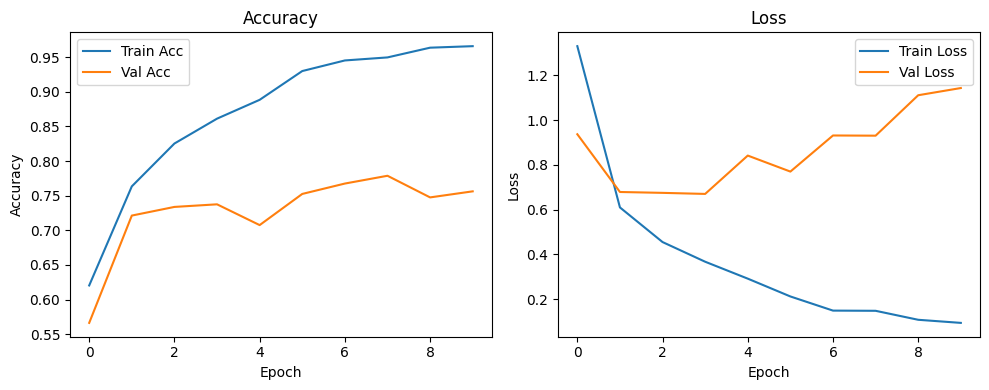

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step


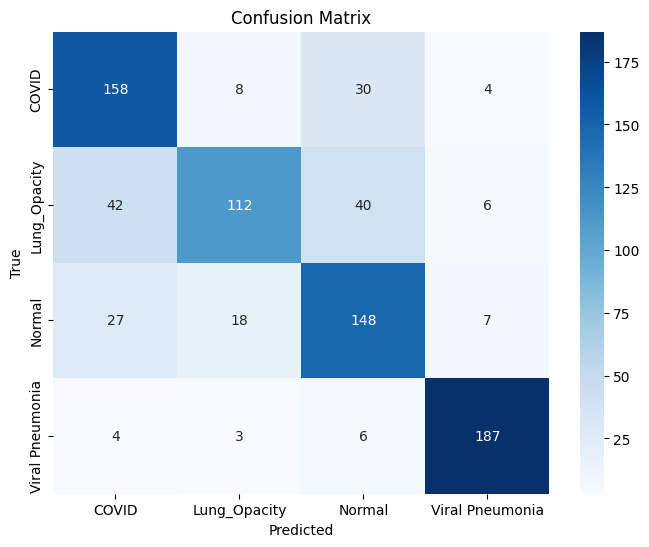

Classification Report:

                 precision    recall  f1-score   support

          COVID       0.68      0.79      0.73       200
   Lung_Opacity       0.79      0.56      0.66       200
         Normal       0.66      0.74      0.70       200
Viral Pneumonia       0.92      0.94      0.93       200

       accuracy                           0.76       800
      macro avg       0.76      0.76      0.75       800
   weighted avg       0.76      0.76      0.75       800



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

val_generator.reset()
Y_true = val_generator.classes
Y_pred = np.argmax(model.predict(val_generator), axis=1)

labels = list(val_generator.class_indices.keys())
cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=labels))

In [ ]:
# save model
model.save("/content/drive/Shared drives/Deepmindset/model/cnn_poc_model.h5")